In [1]:
import gym
import random
import numpy as np
from statistics import median, mean
from collections import Counter
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, LSTM, Input
from keras.optimizers import Adam
from keras.layers.merge import Add

import tensorflow.compat.v1 as tf
from tensorflow.compat.v1.keras import backend as K
tf.disable_eager_execution()

import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import deque

Using TensorFlow backend.


In [2]:
LR = 1e-3
env = gym.make("CartPole-v1")
LEARNING_RATE = 0.001

CartPoleEnv - Version 0.2.0, Noise case: 1


/home/mohanish3/anaconda3/envs/mlproject/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/mohanish3/anaconda3/envs/mlproject/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Environment '<class 'gym.envs.classic_control.cartpole.CartPoleEnv'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
#Plot score over episodes
def plot_res(values, title=''):   
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(500, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(500, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

In [4]:
input_size = env.observation_space.shape
output_size = env.action_space.n

sess = tf.Session()
K.set_session(sess)

actor_critic_grads = tf.placeholder(tf.float32, [None, output_size])
def actor_model(input_size, output_size):
    global LEARNING_RATE

    input_state = Input(shape=input_size)
    output=Dense(24, activation='relu')(input_state)
    #output=Dense(48, activation='relu')(output)
    output=Dense(24, activation='relu')(output)
    output=Dense(output_size, activation='softmax')(output)

    
    model = Model(input=input_state, output=output)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=LEARNING_RATE), metrics=['accuracy'])
    print(model.summary())
    
    return input_state, model

def critic_model(input_size_state, input_size_action):
    LEARNING_RATE
    
    input_state = Input(shape=input_size_state)
    state_hidden = Dense(24, activation='relu')(input_state)
    state_hidden = Dense(24)(state_hidden)
    
    input_action = Input(shape=(input_size_action,))
    action_hidden = Dense(24)(input_action)
    action_hidden = Dense(24)(action_hidden)
    
    output = Add()([state_hidden, action_hidden])
    output = Dense(24, activation='relu')(output)
    output = Dense(1, activation='linear')(output)
    
    model = Model(input=[input_state,input_action], output=output)
    
    model.compile(loss='mse', optimizer=Adam(lr=LEARNING_RATE), metrics=['accuracy'])
    print(model.summary())
    
    return input_state, input_action, model

In [5]:
#Initializiing models with target models(For slow update in DDQL)
actor_input_state,a_model = actor_model(input_size, output_size)
_,a_target_model = actor_model(input_size, output_size)
critic_input_state, critic_input_action, c_model = critic_model(input_size, output_size)
_, _, c_target_model = critic_model(input_size, output_size)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
None


/home/mohanish3/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_5 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 

/home/mohanish3/.local/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 24)           120         input_5[0][0]                    
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 24)           72          input_6[0][0]                    
____________________________________________________________________________________________

In [6]:
actor_model_weights = a_model.trainable_weights
actor_grads = tf.gradients(a_model.output, actor_model_weights, -actor_critic_grads)
grads = zip(actor_grads, actor_model_weights)
optimize = tf.train.AdamOptimizer(LEARNING_RATE).apply_gradients(grads)

critic_grads = tf.gradients(c_model.output, critic_input_action)

sess.run(tf.global_variables_initializer())

In [7]:
def replay_actor(training_samples):
    global sess, critic_grads, critic_input_state, critic_input_action, actor_critic_grads, optimize
    
    states = []
    actions = []
    for t in training_samples:
        state, reward, done, new_state, action = t
        
        act = a_model.predict(np.expand_dims(state, axis=0))[0]
        
        states.append(state)
        actions.append(act)
        
    states = np.array(states)
    actions = np.array(actions)
        
    grads = sess.run(critic_grads, feed_dict={
        critic_input_state:  states, 
        critic_input_action: actions
    })[0]

    sess.run(optimize, feed_dict={
        actor_input_state: states,
        actor_critic_grads: grads
    })
        
def replay_critic(training_samples):
    global epsilon, epsilon_min, epsilon_decay, a_model, c_model, double
    
    states=[]
    actions = []
    y=[]
    for t in training_samples:
        state, reward, done, new_state, action = t
        
        new_state = np.expand_dims(new_state, axis=0)
        
        if(done):
            reward=-reward
        else:
            if not double:
                #Deep q learning
                a = a_model.predict(new_state)
                t = c_model.predict([new_state, a])[0][0]
            else:
                #Double deep q learning
                a = a_target_model.predict(new_state)
                t = c_target_model.predict([new_state, a])[0][0]
            reward = reward + gamma * t
        
        states.append(state)
        actions.append(action)
        y.append(reward)
            
    states = np.array(states)
    actions = np.array(actions)
        
    y = np.expand_dims(np.array(y), axis=1)
    #print(y.shape)
        
    c_model.fit([states, actions], y, batch_size=len(training_samples), verbose=0)
    
def replay(training_data, train_size):
    global epsilon, epsilon_min, epsilon_decay, a_model, c_model
    
    if(len(training_data) < train_size):
        return
    
    batch_data = random.sample(training_data, train_size)
    
    replay_critic(batch_data)
    replay_actor(batch_data)
    
    epsilon = max(epsilon*epsilon_decay, epsilon_min)

In [8]:
def update_actor_target():
    global a_model, a_target_model
    a_target_model.set_weights(a_model.get_weights())
    
def update_critic_target():
    global c_model, c_target_model
    c_target_model.set_weights(c_model.get_weights())
    
def update_targets():
    update_actor_target()
    update_critic_target()

In [9]:
def next_action(state, output_size):
    global epsilon, a_model
    if(np.random.rand() <= epsilon): #Explore: Random action
        act = [0] * output_size
        act[np.random.randint(0, output_size)] = 1
        act = np.array(act, dtype=np.float32)
        return act
    return a_model.predict(np.expand_dims(state, axis=0))[0] #Exploitation: Action with best possible reward

In [10]:
scores = []
game_memory = deque(maxlen=100000)
SCORE_REQUIRED = 500
N=100
last_N_scores = deque(maxlen=N)

SEED=42
np.random.seed(SEED)
random.seed(SEED)
tf.set_random_seed(SEED)

train_size = 32
update_every = 1
goal_steps = 500
TRAIN_EPISODES = 10000

epsilon = 1.0 #Defines the exploration range
epsilon_min = 0.01
epsilon_decay = 0.99
gamma = 0.99

double = False #Double deep q

for game in range(TRAIN_EPISODES):
    state = env.reset()
    
    #env.render()
    score = 0
    for _ in range(goal_steps):
        #print(state.shape)
        #state = np.expand_dims(state, axis=0)
        
        action = next_action(state, output_size)
        
        #print(np.expand_dims(new_state, axis=1))
        #print(action)
                
        new_state, reward, done, info = env.step(np.argmax(action))
        
        score += reward
        
        
        game_memory.append((state, reward, done, new_state, action))
        
        state = new_state
        if done: 
            #print("episode: {}/{}, score: {}, e: {:.2}".format(game, TRAIN_EPISODES, _, epsilon))
            break
    
    if(len(game_memory) < 1000):
        continue
    
    replay(game_memory, train_size)
    
    if(double):
        if game % update_every == 0: #For double deep q learning
            update_targets()
    
    #complete training if last 100 episoes yield more than required score
    last_N_scores.append(score)
    if(sum(last_N_scores)/N >= SCORE_REQUIRED):
        break
    
    if(game % 100 == 0):
        print('Game {} score : {}, epsilon={:.2}'.format(game, score, epsilon))
        scores.append(score)
    
print('Average Score taken every 1000 steps:',sum(scores)/len(scores))

Game 100 score : 11.0, epsilon=0.67
Game 200 score : 12.0, epsilon=0.24
Game 300 score : 10.0, epsilon=0.09
Game 400 score : 30.0, epsilon=0.033
Game 500 score : 95.0, epsilon=0.012
Game 600 score : 102.0, epsilon=0.01
Game 700 score : 119.0, epsilon=0.01
Game 800 score : 107.0, epsilon=0.01
Game 900 score : 101.0, epsilon=0.01
Game 1000 score : 132.0, epsilon=0.01
Game 1100 score : 86.0, epsilon=0.01
Game 1200 score : 233.0, epsilon=0.01
Game 1300 score : 108.0, epsilon=0.01
Game 1400 score : 242.0, epsilon=0.01
Game 1500 score : 168.0, epsilon=0.01
Game 1600 score : 175.0, epsilon=0.01
Game 1700 score : 203.0, epsilon=0.01
Game 1800 score : 173.0, epsilon=0.01
Game 1900 score : 321.0, epsilon=0.01
Game 2000 score : 182.0, epsilon=0.01
Game 2100 score : 167.0, epsilon=0.01
Game 2200 score : 192.0, epsilon=0.01
Game 2300 score : 246.0, epsilon=0.01
Game 2400 score : 76.0, epsilon=0.01
Game 2500 score : 153.0, epsilon=0.01
Game 2600 score : 228.0, epsilon=0.01
Game 2700 score : 125.0, e

In [11]:
a_model.save_weights('a_model.h5')
c_model.save_weights('c_model.h5')

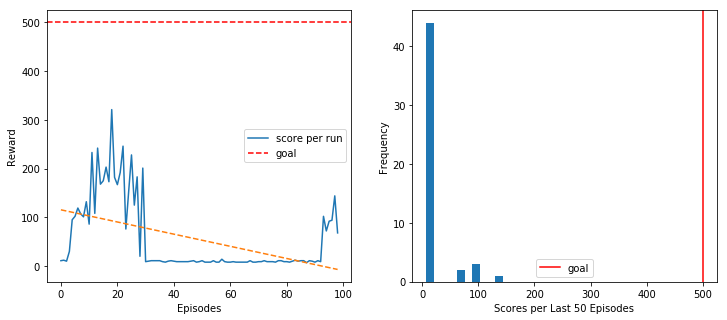

In [12]:
plot_res(scores)

In [13]:
_, a_model = actor_model(env.observation_space.shape, env.action_space.n)
a_model.load_weights('a_model.h5')

/home/mohanish3/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_19 (Dense)             (None, 24)                120       
_________________________________________________________________
dense_20 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
None


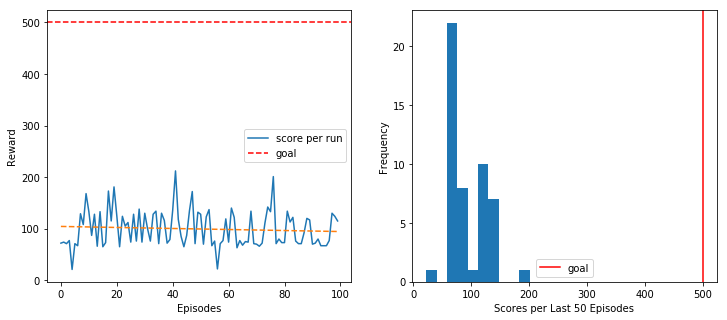

Average score over 100 episodes: 99.47


In [14]:
TEST_EPISODES = 100
goal_steps = 500
epsilon = 0.01
output_size = 2

scores = []
for episode in range(TEST_EPISODES):
    state = env.reset()
    
    score = 0
    for _ in range(goal_steps):
        env.render()
        
        action = next_action(state, output_size)
        
        new_state, reward, done, info = env.step(np.argmax(action))
        score += reward
        
        state = new_state
        if(done):
            break
            
    scores.append(score)
        
plot_res(scores)        
print("Average score over {} episodes: {}".format(TEST_EPISODES, sum(scores)/len(scores)))